## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import pickle
from utils.helper import *

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        write_name = 'output_images/after_camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

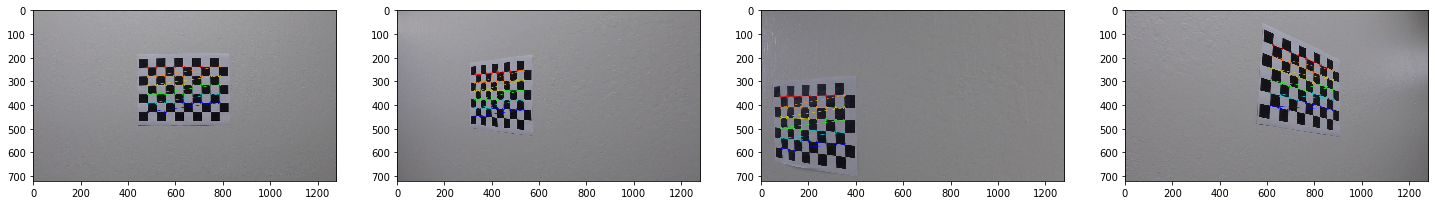

In [3]:
image_names = os.listdir("output_images/after_camera_cal/")
plt.figure(figsize=(25,25))
i = 0
# Only show the first 4 results
for image_name in image_names[0:4]:
    image_dir = "output_images/after_camera_cal/" + image_name
    image = mpimg.imread(image_dir)
    plt.subplot(5,4,i+1)
    i += 1
    plt.imshow(image)
plt.show()

Text(0.5, 1.0, 'Undistorted Image')

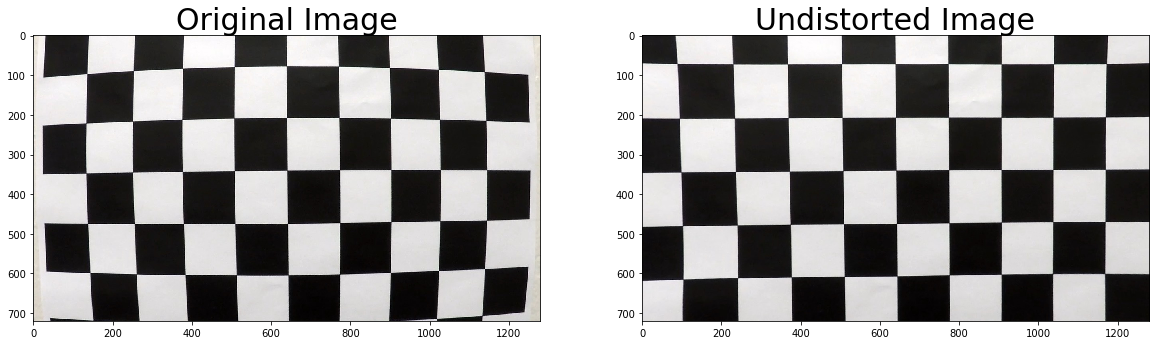

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/calibration_wide/wide_dist_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

# Apply a distortion correction to raw images

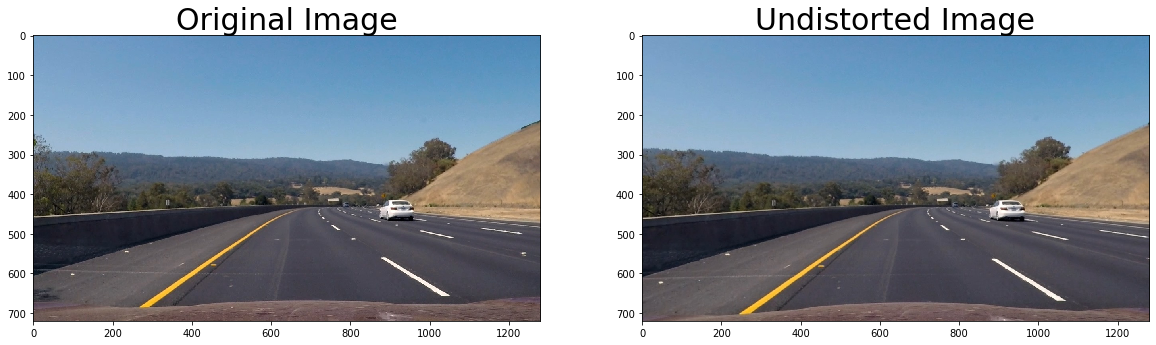

In [5]:
image_names = os.listdir("test_images/")
for image_name in image_names:
    img = cv2.imread('test_images/'+image_name)
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'output_images/calibration_wide/'+image_name
    cv2.imwrite(write_name, dst_img)

# Only show one example
img = cv2.imread('test_images/test3.jpg')
dst_img = cv2.imread('output_images/calibration_wide/test3.jpg')
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Original Image', fontsize=30)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('Undistorted Image', fontsize=30)
plt.imshow(cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB))
plt.show()

# Apply a perspective transform to rectify binary image ("birds-eye view")

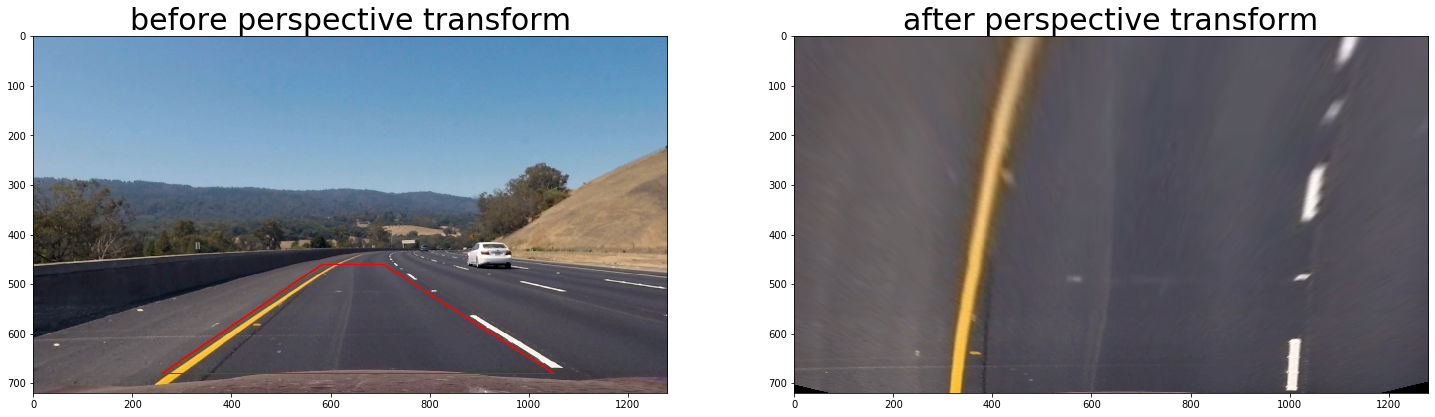

In [6]:
dst_img = cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)
offset = 300
w, h = dst_img.shape[1], dst_img.shape[0]
dst = np.float32([[offset, 0], [w-offset, 0], [offset, h], [w-offset, h]])
src = np.float32([(582,460), (705,460), (260,680), (1050,680)])

warped = perspective_transform(dst_img, src, dst)

img_show = np.copy(dst_img)
cv2.line(img_show, (src[0][0],src[0][1]) , (src[1][0],src[1][1]), [255,0,0], 2)
cv2.line(img_show, (src[1][0],src[1][1]) , (src[3][0],src[3][1]), [255,0,0], 2)
cv2.line(img_show, (src[0][0],src[0][1]) , (src[2][0],src[2][1]), [255,0,0], 2)
cv2.line(img_show, (src[2][0],src[2][1]) , (src[3][0],src[3][1]), [255,0,0], 2)

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.title('before perspective transform', fontsize=30)
plt.imshow(img_show)
plt.subplot(1,2,2)
plt.title('after perspective transform', fontsize=30)
plt.imshow(warped)

# Use color transforms, gradients, etc., to create a thresholded binary image

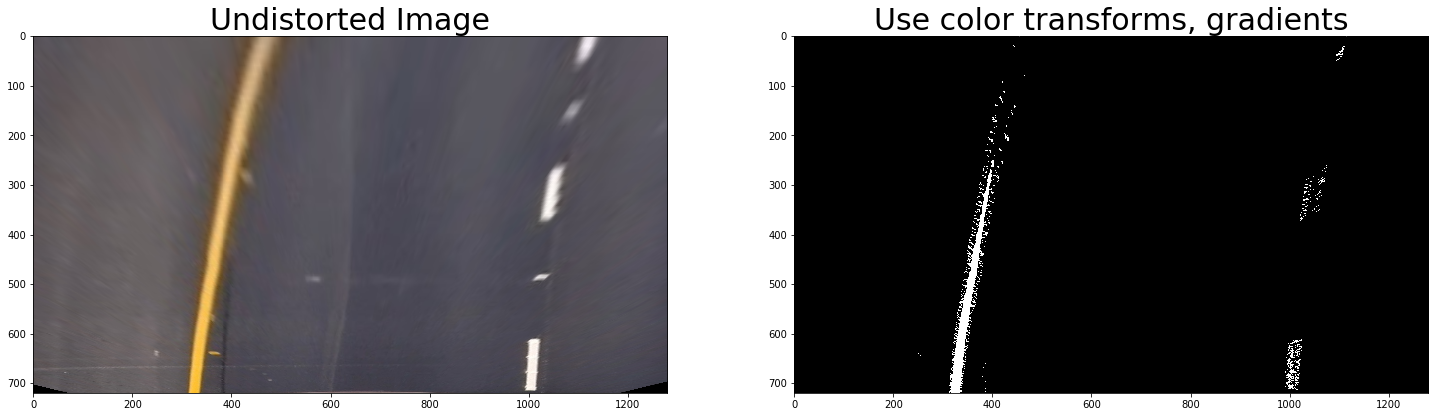

In [7]:
sx_thresh=(15, 255)
dir_thresh=(0, np.pi/32)
s_thresh=(180, 255)

combined_binary = grad_col_threshold(warped, sx_thresh, dir_thresh, s_thresh)

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.title('Undistorted Image', fontsize=30)
plt.imshow(warped)
plt.subplot(1,2,2)
plt.title('Use color transforms, gradients', fontsize=30)
plt.imshow(combined_binary, cmap='gray')

# Determine the curvature of the lane and vehicle position with respect to center

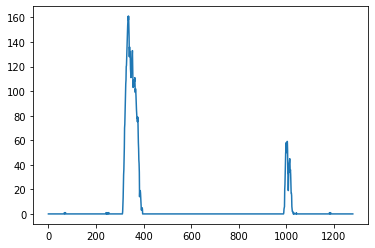

In [8]:
# Create histogram of image binary activations
histogram = hist(combined_binary)
# Visualize the resulting histogram
plt.plot(histogram)

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

### determine shift with respect to center

In [10]:
midpoint = np.int(histogram.shape[0] // 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint        
center = (leftx_base + rightx_base) / 2
shift = (center - midpoint) * xm_per_pix
if shift <= 0:
    text2 = 'Shift ' + '{:2.2f}'.format(-shift) + 'm to left'
else:
    text2 = 'Shift ' + '{:2.2f}'.format(shift) + 'm to right'
print(text2)

Shift 0.15m to right


### determine curvature of the lane

Curve radius: 1.64km


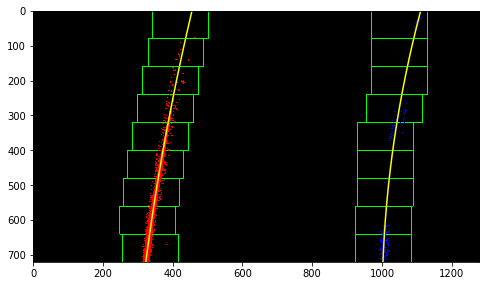

In [11]:
out_img, left_fit, right_fit, left_curverad, right_curverad, left_fitx, right_fitx, ploty = fit_polynomial(combined_binary, ym_per_pix, xm_per_pix)
plt.figure(figsize=(8,8))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
text1 = 'Curve radius: ' + '{:2.2f}'.format((left_curverad + right_curverad) / 2000) + 'km'
print(text1)

In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

newwarp = perspective_transform(color_warp, dst, src)
# Combine the result with the original image
result = cv2.addWeighted(cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)

font = cv2.FONT_HERSHEY_DUPLEX
cv2.putText(result, text1, (40, 70), font, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
cv2.putText(result, text2, (40, 150), font, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

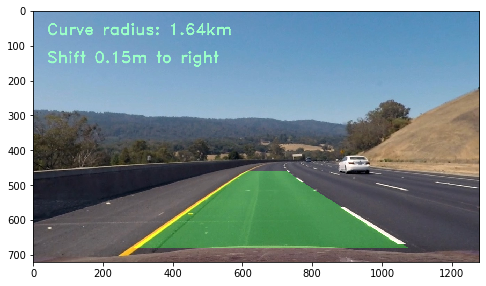

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(result)